## Predicting preferred accommodation for a personalized travel recommendation system
### Nazly Santos-Buitrago
### Qualogy test case

Resources: 
train_data.txt 
TestDataAccommodation.csv

## Preprocessing 

Some preprocessing is needed before we can explore the dataset:
1. The train data is in one-single column format, we will convert it into a DataFrame for easy handling. 
2. There is presence of missing values ("NA") that need to be modified before using the dataset. 

In [1]:
#Import of data manipulation libraries
import pandas as pd
import numpy as np

In [2]:
#Import txt training data into pandas dataframe
#We split the 2 columns in the file, and don't specify header
#it is assumed the file is present in the same directory of this jupyter notebook
df_file = pd.read_csv('train_data.txt', delimiter=' ' , header=None )

In [3]:
df_file.head(n=10)

,0,1
0,[1],Record 1
1,[1],1010286
2,[1],7
3,[1],F
4,[1],40
5,[1],0
6,[1],SE
7,[1],Apt
8,[1],Record 2
9,[1],1000152


In [4]:
#The variables of the dataset were given in the problem description
headers = ["cell","id", "durationOfStay", "gender", "Age", "kids", "destinationCode", "AcomType"]

In [5]:
#We use some auxiliar variables to do reshape and keep only the variables of interest
#1.Delete the first column which contains only [1]'s values
df1 = df_file.drop([0], axis=1 )
#2.We take the values of the dataframe to get a numpy array
df2 = df1.values
#3.We know there are 8 variables in the data set and the lenght of the array is 78944 (df2.size)
#therefore, we can reshape the array in the desire format
columns = len(headers)
rows = df2.size//columns
data = df2.reshape((rows,columns))

In [6]:
#now that the data is in the right shape, we convert it to dataframe again to do some exploration
df = pd.DataFrame(data, columns=headers)
#we replace the '<NA>' string values for non values
df.replace('<NA>',np.nan, inplace=True)
#for exploring the data in external tools, we also export it as csv
df.to_csv('data_processed.csv')

In [7]:
#the processed raw data looks like
df.head()

,cell,id,durationOfStay,gender,Age,kids,destinationCode,AcomType
0,Record 1,1010286,7,F,40,0,SE,Apt
1,Record 2,1000152,5,M,NaN,0,NaN,Apt
2,Record 3,1009019,4,F,39,1,ES,Hotel
3,Record 4,1007840,5,F,45,0,NL,Hotel
4,Record 5,1006939,5,M,45,1,UK,Hotel


## Exploration

With the dataframe we can perform basic description of the data and distribution of variables

In [8]:
df.describe()

,cell,id,durationOfStay,gender,Age,kids,destinationCode,AcomType
count,9868,9868,9868,9868,8874,8897,8872,9868
unique,9868,9868,13,2,37,2,8,2
top,Record 7017,1000182,4,F,40,1,BE,Hotel
freq,1,1,2257,4981,714,4488,1161,5592


In [9]:
df["destinationCode"].value_counts()

BE    1161
SE    1150
IT    1114
FI    1107
NL    1101
DK    1095
UK    1086
ES    1058
Name: destinationCode, dtype: int64

In [10]:
df["durationOfStay"].value_counts()

4     2257
3     2208
5     1609
2     1484
6      980
7      536
1      475
8      218
9       67
10      24
12       4
11       4
13       2
Name: durationOfStay, dtype: int64

In [11]:
#variables Age and durationOfStay could be transformed into numerical
df['Age'] = pd.to_numeric(df['Age'])
df['durationOfStay'] = pd.to_numeric(df['durationOfStay'])

In [12]:
#describing only numerical variables (df.dtypes)
df.describe(include=['float','int64'])

,durationOfStay,Age
count,9868.000000,8874.000000
mean,4.000507,40.415596
std,1.726542,5.037572
min,1.000000,22.000000
25%,3.000000,37.000000
50%,4.000000,40.000000
75%,5.000000,44.000000
max,13.000000,59.000000


## Preparing the data as input for a model

Before being able to use the dataset as input for any model, we need to select and prepare the variables as features.  
1. The dataset contains four categorical variables. We need to do some transformations to put the string values into the right format. 
2. There is presence of null values. For both categorical and numerical variables, it is necessary to remove the NaN values in such a way that it does not affect the semantics of the feature. 

In [13]:
#we create a copy of the dataframe to work with it
df_X_train = df.copy()
#variable gender used to create a category with numerical codes
df_X_train['gender_cat'] = df_X_train['gender'].astype('category').cat.codes
#destinationCode converted to one-hot encoding creating 8 new columns
#variable kids converted in one-hot encoding to deal with missing values
df_X_train_1 = pd.get_dummies(df_X_train, columns=["destinationCode", "kids"])
#null values in Age replaced by its mean
df_X_train_1['Age'] = df_X_train['Age'].fillna(df_X_train['Age'].mean())

#Finally we delete the columns that are not going to be used in the model:
#the original categorical variables and the target AcomType

df_X_train = df_X_train_1.drop(['cell','id','AcomType', 'gender'], axis=1 )


In [14]:
#the training data looks like
df_X_train.head()

,durationOfStay,Age,gender_cat,destinationCode_BE,destinationCode_DK,destinationCode_ES,destinationCode_FI,destinationCode_IT,destinationCode_NL,destinationCode_SE,destinationCode_UK,kids_0,kids_1
0,7,40.000000,0,0,0,0,0,0,0,1,0,1,0
1,5,40.415596,1,0,0,0,0,0,0,0,0,1,0
2,4,39.000000,0,0,0,1,0,0,0,0,0,0,1
3,5,45.000000,0,0,0,0,0,0,1,0,0,1,0
4,5,45.000000,1,0,0,0,0,0,0,0,1,0,1


In [15]:
#now we can generate the training dataset in array format
#for AcomType we also convert to category and get the numerical codes Apt = 0 , Hotel = 1
X= df_X_train.values
y = df['AcomType'].astype('category').cat.codes.values

## Modeling

### Supervised learning

With the data ready to consume, we can approach the problem as a classification task, in which the objective is to predict the variable AcomType. 
Using the Sklearn package of Python we will run different models to understand which one could perform better in this task. 
The original data has 9869 labeled datapoints. 
We first need to split the dataset into a training and a test dataset to be able to evaluate and compare the models. 

In [16]:
#import machine learning libraries
#metrics and data handling
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
#ploting library for display ROC curve
import matplotlib.pyplot as plt 

#import machine learning models
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


In [17]:
#getting the split datasets training and test for evaluation of the models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [18]:
#setting real label for metrics
y_true = y_test

For all the models the pipeline will be as follow: 
1. Instantiate a classification algorithm named clf
2. Train the algorithm using the X_train and y_train, normally using its fit method
3. Apply the learned model to X_test, aiming to predict y_pred
4. Compute metrics of accuracy between the true label y_true and the predicted y_pred
5. Check the performance of the model in terms of true positive rate and false positive rate using ROC curve and AUROC score

## Decision Tree

Given the size of the dataset and the nature of the features, a first algorithm to try is the Decision tree. Also, aiming to give an interpretability about which variables played a role in the decision making. 

In [41]:
#creating the model
clf = tree.DecisionTreeClassifier()#max_leaf_nodes=20
#training with the training split 
clf = clf.fit(X_train, y_train)

In [42]:
tree_info = clf.tree_
tree_info.node_count

4413

In [38]:
#prediction for the test split, using values, not probabilities
y_pred = clf.predict(X_test)

In [32]:
#evaluation of the model with accuracy of prediction 
accuracy_score(y_true, y_pred)

0.70162107396149953

In [33]:
#confusion matrix
metrics.confusion_matrix(y_true,y_pred)

array([[615, 240],
       [349, 770]], dtype=int64)

In [34]:
#obtaining the prediction as probabilities for AUROC
y_pred_prob = clf.predict_proba(X_test)
#getting only one column of the result for one class
y_pred_new = []
for i in range(y_pred_prob.shape[0]):
    y_pred_new_ = y_pred_new.append(y_pred_prob[i][0])

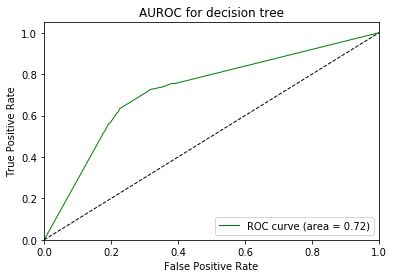

In [35]:
#AUROC

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_new, pos_label=0)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 1
plt.plot(fpr, tpr, color='g',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC for decision tree')
plt.legend(loc="lower right")
plt.show()

In [43]:
#exporting the resulting tree as a dot file for visualization purposes 
dot_data = tree.export_graphviz(clf, out_file='tree.dot', 
                     feature_names=df_X_train.columns,  
                      class_names=['apto', 'hotel'])  


## Logistic Regression

For exploration of other models, and possibly understand if the data is linearly separable, also given that the problem is binary classification, we could try to apply logistic regression. 

In [44]:
#creating the model
clf = LogisticRegression()
#training with the training split 
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
#prediction for the test split, using values, not probabilities
y_pred = clf.predict(X_test)

In [46]:
accuracy_score(y_true, y_pred)

0.56686930091185406

In [47]:
#obtaining the prediction as probabilities for AUROC
y_pred_prob = clf.predict_proba(X_test)
#getting only one column of the result for one class
y_pred_new = []
for i in range(y_pred_prob.shape[0]):
    y_pred_new_ = y_pred_new.append(y_pred_prob[i][0])

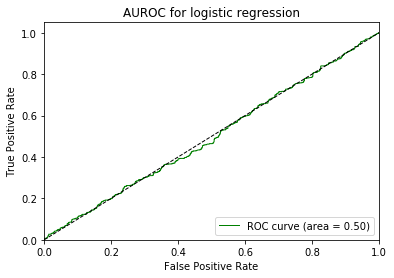

In [48]:
#AUROC

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_new, pos_label=0)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 1
plt.plot(fpr, tpr, color='g',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC for logistic regression')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [74]:
#giving the random nature of the model, in previous training the maximun accuracy was 0.749
accuracy_score(y_true, y_pred)

0.73860182370820671

In [76]:
clf_rforest = clf 

In [57]:
#obtaining the prediction as probabilities for AUROC
y_pred_prob = clf.predict_proba(X_test)
#getting only one column of the result for one class
y_pred_new = []
for i in range(y_pred_prob.shape[0]):
    y_pred_new_ = y_pred_new.append(y_pred_prob[i][0])

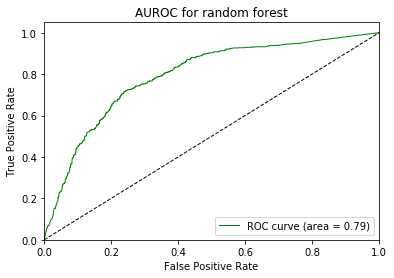

In [58]:
#AUROC

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_new, pos_label=0)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 1
plt.plot(fpr, tpr, color='g',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC for random forest')
plt.legend(loc="lower right")
plt.show()

## Naive Bayes

In [59]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None)

In [60]:
y_pred = clf.predict(X_test)

In [61]:
accuracy_score(y_true, y_pred)

0.5435663627152989

### Neural Network MLP 

In [62]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                  hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [63]:
y_pred = clf.predict(X_test)
accuracy_score(y_true, y_pred)

0.56686930091185406

In [64]:
#obtaining the prediction as probabilities for AUROC
y_pred_prob = clf.predict_proba(X_test)
#getting only one column of the result for one class
y_pred_new = []
for i in range(y_pred_prob.shape[0]):
    y_pred_new_ = y_pred_new.append(y_pred_prob[i][0])

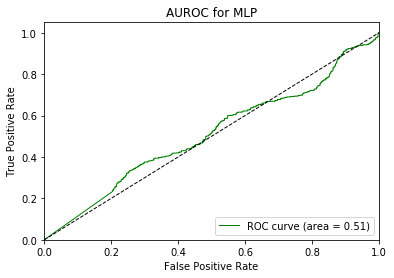

In [66]:
#AUROC

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_new, pos_label=0)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 1
plt.plot(fpr, tpr, color='g',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC for MLP')
plt.legend(loc="lower right")
plt.show()

## Application of the model into the new data

Solving the exercise, we will apply the random forest algorithm, given that it was the best performing among the other options. 
For giving the dataset as input to the model, we will apply the same preprocessing and preparation that we did to the training data. 

In [67]:
#it is assumed the file is present in the same directory of this jupyter notebook
df_test_file = pd.read_csv('TestDataAccomodation.csv')

In [68]:
#we replace the '<NA>' string values for non values
df_test_file.replace('<NA>',np.nan, inplace=True)

In [69]:
#how the new data looks like
df_test_file.head(n=10)

,id,durationOfStay,gender,Age,kids,destinationCode,AcomType
0,1013319,2,F,38.0,0.0,BE,NaN
1,1009485,6,M,37.0,0.0,ES,NaN
2,1002725,1,M,37.0,1.0,ES,NaN
3,1001133,5,F,50.0,0.0,UK,NaN
4,1000794,4,F,42.0,1.0,DK,NaN
5,1010220,4,M,NaN,1.0,FI,NaN
6,1011735,2,F,40.0,0.0,BE,NaN
7,1003306,2,F,38.0,1.0,UK,NaN
8,1005848,2,F,31.0,NaN,ES,NaN
9,1013199,3,M,37.0,0.0,NL,NaN


In [70]:
#we create a copy of the dataframe to work with it
df_X_newData = df_test_file.copy()

In [71]:
#variable gender used to create a category with numerical codes
df_X_newData['gender_cat'] = df_X_newData['gender'].astype('category').cat.codes
#destinationCode converted to one-hot encoding creating 8 new columns
#variable kids converted in one-hot encoding to deal with missing values
df_X_newData_1 = pd.get_dummies(df_X_newData, columns=["destinationCode", "kids"])
#null values in Age replaced by its mean
df_X_newData_1['Age'] = df_X_newData['Age'].fillna(df_X_newData['Age'].mean())

#Finally we delete the columns that are not going to be used in the model:
#the original categorical variables and the target AcomType

df_X_newData = df_X_newData_1.drop(['id','AcomType', 'gender'], axis=1 )


In [72]:
df_X_newData.head()

,durationOfStay,Age,gender_cat,destinationCode_BE,destinationCode_DK,destinationCode_ES,destinationCode_FI,destinationCode_IT,destinationCode_NL,destinationCode_SE,destinationCode_UK,kids_0.0,kids_1.0
0,2,38.0,0,1,0,0,0,0,0,0,0,1,0
1,6,37.0,1,0,0,1,0,0,0,0,0,1,0
2,1,37.0,1,0,0,1,0,0,0,0,0,0,1
3,5,50.0,0,0,0,0,0,0,0,0,1,1,0
4,4,42.0,0,0,1,0,0,0,0,0,0,0,1


We will use our pre trained Random Forest to predict the new label AcomType

In [77]:
y_pred = clf_rforest.predict(df_X_newData.values)

In [78]:
#generating output file
df_X_newData['pred_AcomType'] = y_pred

In [79]:
df_X_newData.head(n=20)

,durationOfStay,Age,gender_cat,destinationCode_BE,destinationCode_DK,destinationCode_ES,destinationCode_FI,destinationCode_IT,destinationCode_NL,destinationCode_SE,destinationCode_UK,kids_0.0,kids_1.0,pred_AcomType
0,2,38.000000,0,1,0,0,0,0,0,0,0,1,0,0
1,6,37.000000,1,0,0,1,0,0,0,0,0,1,0,1
2,1,37.000000,1,0,0,1,0,0,0,0,0,0,1,0
3,5,50.000000,0,0,0,0,0,0,0,0,1,1,0,1
4,4,42.000000,0,0,1,0,0,0,0,0,0,0,1,0
5,4,40.528579,1,0,0,0,1,0,0,0,0,0,1,1
6,2,40.000000,0,1,0,0,0,0,0,0,0,1,0,1
7,2,38.000000,0,0,0,0,0,0,0,0,1,0,1,1
8,2,31.000000,0,0,0,1,0,0,0,0,0,0,0,1
9,3,37.000000,1,0,0,0,0,0,1,0,0,1,0,1


In [83]:
#adding the new column to the original dataset and replacing it for the original values name
df_test_file['AcomType'] = df_X_newData['pred_AcomType']
df_test_file[df_test_file['AcomType']==0 ] = 'Apto'
df_test_file[df_test_file['AcomType']==1 ] = 'Hotel'

In [84]:
df_test_file.head()

,id,durationOfStay,gender,Age,kids,destinationCode,AcomType
0,Apto,Apto,Apto,Apto,Apto,Apto,Apto
1,Hotel,Hotel,Hotel,Hotel,Hotel,Hotel,Hotel
2,Apto,Apto,Apto,Apto,Apto,Apto,Apto
3,Hotel,Hotel,Hotel,Hotel,Hotel,Hotel,Hotel
4,Apto,Apto,Apto,Apto,Apto,Apto,Apto


In [85]:
#export resulting file into csv
df_test_file.to_csv('TestDataAccommodation_pred.csv')